# In Seattle or San Francisco is better to not own a CAR (to not being stolen)

## What plotting (mainly) needs

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


## Helper functions for loading data

it loads data into a dictionary 

In [3]:
import csv
def load_data(data_file_csv):
    ''' Loads csv data file '''
    data_dict = {'rows':[]} 
    with open (data_file_csv, "r") as data_file:
        reader = csv.DictReader(data_file)
        data_dict['header'] = reader.fieldnames
        for row in reader:
            data_dict['rows'].append(row)
    return data_dict

def print_columns_names(data_dict):
    print "the data has {0} fields (columns):".format(len(data_dict['header']))
    for field_name in data_dict['header'][:-1]:
        print field_name+',',
    print data_dict['header'][-1]
    

## Loading incidents data for Seattle and San Francisco
In this section we load data for seattle and examine some global data information

In [4]:
# Loading data
seattle_is14_data = load_data('seattle_incidents_summer_2014.csv')
sanfrancisco_is14_data = load_data('sanfrancisco_incidents_summer_2014.csv')

# Adding some useful keys 
seattle_is14_data['city'] = 'Seattle'
seattle_is14_data['color'] = 'red'

sanfrancisco_is14_data['city'] = 'San Francisco'
sanfrancisco_is14_data['color'] = 'blue'

 Global information and field analysis for normalization (fur further comparison):
 

In [5]:
print 'Seattle summer 2014:'
print_columns_names(seattle_is14_data)

Seattle summer 2014:
the data has 19 fields (columns):
RMS CDW ID, General Offense Number, Offense Code, Offense Code Extension, Offense Type, Summary Offense Code, Summarized Offense Description, Date Reported, Occurred Date or Date Range Start, Occurred Date Range End, Hundred Block Location, District/Sector, Zone/Beat, Census Tract 2000, Longitude, Latitude, Location, Month, Year


In [6]:
print 'SanFrancisco summer incident summer 14 fields'
print_columns_names(sanfrancisco_is14_data)

SanFrancisco summer incident summer 14 fields
the data has 13 fields (columns):
IncidntNum, Category, Descript, DayOfWeek, Date, Time, PdDistrict, Resolution, Address, X, Y, Location, PdId


as the fields number and names reveal the two datasets do not have the same schema (and needs some normalizing effort to be compare)

## Generic count histogram build + plot  ...

In [7]:
# Helper function to build (count) dictionary for histogram    
def build_hist_dict(data, field='type_incid_desc', item_filter = lambda x: True):
    """ Build count dictionary which supports items filtering. """
    hist_dict = {}
    for item in data.get('rows', []):
        if item_filter(item):
            assert field in item
            hist_dict[item[field]] = hist_dict.get(item[field], 0) + 1
    return hist_dict

def plot_hist_dict(data, field, top_k=10, color='blue', title='', item_filter = lambda x: True):
    """ build and plot hist dict. """
    hist_dict = build_hist_dict(data, field=field, item_filter=item_filter)
    top_k_items = sorted ([(k,v) for k,v in hist_dict.iteritems()], key = lambda x: x[1], reverse= True)[:top_k]
    top_k_items.reverse()
    ticks_labels, y = zip(*top_k_items)
    f, ax = plt.subplots(figsize=(6, int(len(top_k_items)/3)))
    ax.set_title(title + ' ' + data['city'])
    #ax.set_xticks(range(top_k))
    ax.grid()
    width = 0.8
    
    #ax.set_xticklabels(ticks_labels, rotation=90 )
    #ax.bar(range(len(y)),list(y), width= width, color=data['color'])
    
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(ticks_labels)
    ax.barh(range(len(y)), list(y), color=data['color'])

# Making the datasets more homogenous for comparison 

## Location : exploring/cleaning  location (values)

it appears that X is latitude and Y is longitude for SanFransisco data and Location matches (hold the same data type) 
for both SanFransisco and Seattle, also Descript (SF) and Offense Type (Seattle) seems to contain comparable information

In [8]:
# Cleaning redundant location data
for item in sanfrancisco_is14_data['rows']:
    if 'X' in item:
        del item ['X']
    if 'Y' in item:
        del item['Y']

for item in seattle_is14_data['rows']:
    if 'Latitude' in item:
        del item['Latitude']
    if 'Longitude' in item: 
        del item['Longitude']
    
# clean/transform/type-cast location is  item['loc'] = {'lat': x., 'lon': y.}, and remove all other location fields
def build_location_dict(item):
    if 'loc' not in item: # Multiple applications
        lat, lon = map(float,item.get('Location')[1:-1].split(','))
        item['loc'] = {'lat': lat, 'lon': lon}
    if 'loc' in item:
        if 'Location' in item:
            del item['Location']
            
# Apply the cleaning process on the datasets
for item in sanfrancisco_is14_data['rows']:
    build_location_dict(item)
for item in seattle_is14_data['rows']:
    build_location_dict(item)

Now let's add a median (or mean) incident location for each dataset to be used for Visualiztion (to center the map), an other choice is to google the coordinate for seattle and san francisco and inject them into the data (but it's kind of dirty way), let's prioritize/exploit what we already have in our data, and it might be nicer (might have an additional insight)


In [9]:
# Mean incident location for each city 
import numpy as np
def add_median_incident_loc(data):
    if 'm_loc' not in data:
        data['m_loc'] = {'lat': np.median([item['loc']['lat'] for item in data['rows']]),
                             'lon': np.median([item['loc']['lon'] for item in data['rows']])
                            }
add_median_incident_loc(sanfrancisco_is14_data)
add_median_incident_loc(seattle_is14_data)
# seattle_is14_data['m_loc']

In [10]:
# Gen Bounding box for region
def add_reg_bbox(data):
    if 'reg_bbox' not in data:
        data['reg_bbox'] = {'llcrnrlat': np.min([item['loc']['lat'] for item in data['rows']]),
                         'llcrnrlon': np.min([item['loc']['lon'] for item in data['rows']]),
                         'urcrnrlat': np.max([item['loc']['lat'] for item in data['rows']]),
                         'urcrnrlon': np.max([item['loc']['lon'] for item in data['rows']])
                            }
add_reg_bbox(sanfrancisco_is14_data)
add_reg_bbox(seattle_is14_data)

## Normlize district 
the motivation here is just for code factorization

In [11]:
# let's normalize the destrict  (rename it to district_sector)
for item in seattle_is14_data['rows']:
    if 'District/Sector' in item:
        item['district_sector'] = item['District/Sector']
        del item['District/Sector']

for item in sanfrancisco_is14_data['rows']:
    if 'PdDistrict' in item:
        item['district_sector'] = item['PdDistrict']
        del item['PdDistrict']
        
#for item in seattle_is14_data['rows']:
#        print item['Zone/Beat']

## Globally (all incidents types), Where they happen the most (Neighbourhood)

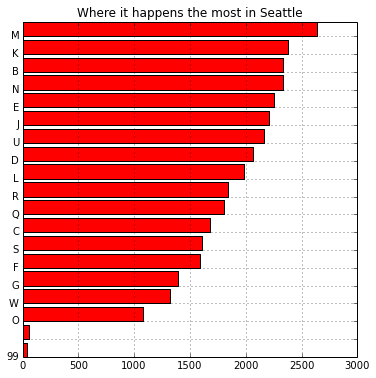

In [12]:
plot_hist_dict(seattle_is14_data,'district_sector', top_k=20, title = 'Where it happens the most in')

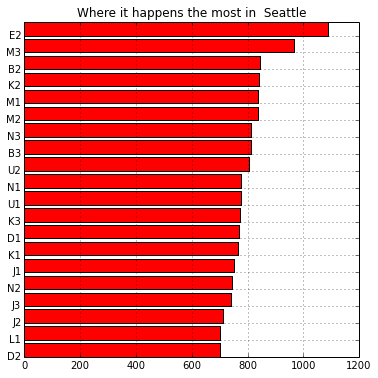

In [13]:
plot_hist_dict(seattle_is14_data,'Zone/Beat', top_k=20, title = 'Where it happens the most in ')

In [25]:
def add_shape_file(data, shapefilename):
    data['shapefilename'] = shapefilename

add_shape_file(seattle_is14_data, 'Seattle/Neighborhoods/WGS84/Neighborhoods')
add_shape_file(sanfrancisco_is14_data,'SanFrancisco/Realtor_Neighborhoods/WGS84_converted')


In [41]:
import gis_visu
reload(gis_visu)
from gis_visu import plot_data

-122.236044455 -122.435955898 47.7341649468 47.495513624


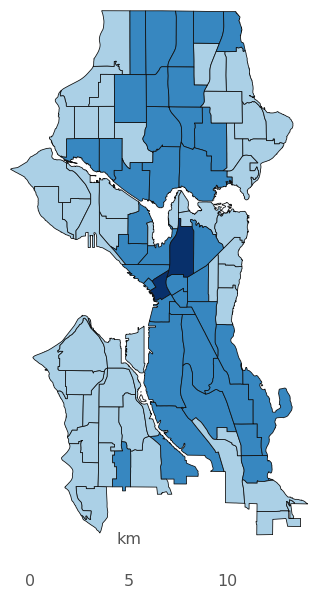

In [42]:
plot_data(seattle_is14_data)

50.1156472954 49.585021399 41.3096951624 40.8835850372


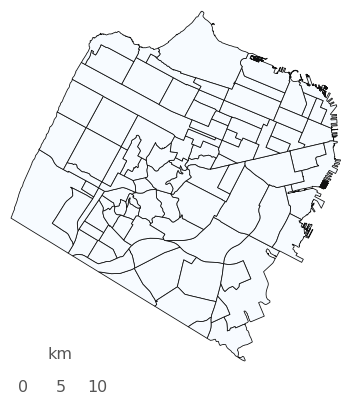

In [43]:
add_shape_file(sanfrancisco_is14_data,'SanFrancisco/Realtor_Neighborhoods/test')
plot_data(sanfrancisco_is14_data)


In [138]:
shp = fiona.open(seattle_is14_data.get('shapefilename')+'.shp') # why '.shp' is separated because of  readshapefile 
print shp.driver
print shp.items
coords = shp.bounds

w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01
print w, h
print coords[2], coords[0], coords[3], coords[1]

for item in shp.items():
    print item
shp.close()


ESRI Shapefile
<bound method Collection.items of <open Collection 'Seattle/Neighborhoods/WGS84/Neighborhoods.shp:Neighborhoods', mode 'r' at 0x116474350>>
0.199911443036 0.238651322869
-122.236044455 -122.435955898 47.7341649468 47.495513624
(0, {'geometry': {'type': 'Polygon', 'coordinates': [[(-122.27397895293998, 47.695226472663656), (-122.27409168130465, 47.6952639921772), (-122.27416596165186, 47.69530636757674), (-122.27422133445985, 47.69532597510108), (-122.27428547630623, 47.69533227627196), (-122.27435972282612, 47.69533682149507), (-122.27452057906403, 47.69535235337489), (-122.27462761674825, 47.695367708543564), (-122.27476154688902, 47.69540084625938), (-122.27486479955861, 47.69542614611331), (-122.27494982717457, 47.69545330420073), (-122.27504271399823, 47.69550752552892), (-122.27508652283421, 47.69554947187938), (-122.27505647571276, 47.69556437585359), (-122.27496776311975, 47.695514214768735), (-122.27488321789812, 47.695467856678164), (-122.27480765198857, 47.6954

In [40]:
# Testing SF data ...

shp = fiona.open(sanfrancisco_is14_data.get('shapefilename')+'.shp') # why '.shp' is separated because of  readshapefile 
print shp.driver
for item in shp.items():
    print item[1]['properties']['nbrhood']
coords = shp.bounds
shp.close()
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01
print w, h
print coords[2], coords[0], coords[3], coords[1]

print sanfrancisco_is14_data['m_loc']


ESRI Shapefile
Alamo Square
Anza Vista
Balboa Terrace
Bayview
Bernal Heights
Buena Vista Park/Ashbury Heights
Central Richmond
Central Sunset
Clarendon Heights
Corona Heights
Cow Hollow
Crocker Amazon
Diamond Heights
Downtown
Duboce Triangle
Eureka Valley / Dolores Heights
Excelsior
Financial District/Barbary Coast
Yerba Buena
Forest Hill
Forest Hills Extension
Forest Knolls
Glen Park
Golden Gate Heights
Golden Gate Park
Haight Ashbury
Hayes Valley
Ingleside
Ingleside Heights
Ingleside Terrace
Inner Mission
Inner Parkside
Inner Richmond
Inner Sunset
Jordan Park / Laurel Heights
Lake Street
Lake Shore
Lakeside
Lone Mountain
Lower Pacific Heights
Marina
Merced Heights
Merced Manor
Midtown Terrace
Miraloma Park
Mission Bay
Mission Dolores
Mission Terrace
Monterey Heights
Mount Davidson Manor
Noe Valley
North Beach
North Panhandle
North Waterfront
Oceanview
Outer Mission
Outer Parkside
Outer Richmond
Outer Sunset
Pacific Heights
Parkside
Cole Valley/Parnassus Heights
Pine Lake Park
Portola

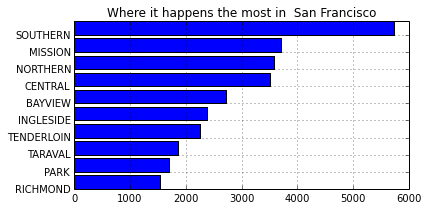

In [16]:
plot_hist_dict(sanfrancisco_is14_data,'district_sector', top_k=20, title = 'Where it happens the most in ')

At least for San Francisco the content of district sector, is user friendly (meaningful values).

<img src="http://www.sfdistrictattorney.org/modules/showimage.aspx?imageid=182" style="max-width:100%; width: 70%">

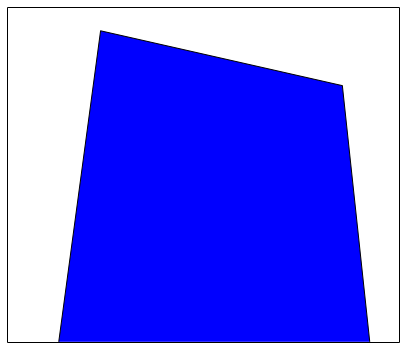

In [74]:
# Testing Basemap with Sanfrancisco

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-160, urcrnrlon=160, resolution='l')
# m = Basemap(projection='merc', lat_0=57, lon_0=-135,
#    resolution = 'l', area_thresh = 1000.0,
#    llcrnrlon=-136.25, llcrnrlat=56,
#    urcrnrlon=-134.25, urcrnrlat=57.75)
zoom_out = 0.
m = Basemap(projection='mill',
            resolution = 'l', area_thresh = 3000.0,
            llcrnrlon=sanfrancisco_is14_data['reg_bbox']['llcrnrlon']-zoom_out, 
            llcrnrlat=sanfrancisco_is14_data['reg_bbox']['llcrnrlat']-zoom_out,
            urcrnrlon=sanfrancisco_is14_data['reg_bbox']['urcrnrlon']+zoom_out,
            urcrnrlat=sanfrancisco_is14_data['reg_bbox']['urcrnrlat']+zoom_out)

m.drawcoastlines()
m.fillcontinents(color='blue')
#m.bluemarble()

m.drawmapboundary()

plt.show()

##  Incident description : source (field) choice and  "cleaning"

Some (description) fields alues prints,  reveal that a respectively for San Francisco and Seattle dataset, the fields 'Descript' and 'Offense Type' can be concidered for incident description so we "simplify" the description to be the content of these columns

In [17]:
# Normalizing description and offense type fields for both data, (mapping fields name not the values)
for item in sanfrancisco_is14_data['rows']:
    if 'Descript' in  item:
        item['type_incid_desc'] =  item['Descript']
        del item['Descript']
for item in seattle_is14_data['rows']:
    if 'Offense Type' in item:
        item['type_incid_desc'] = item['Offense Type']
        del item['Offense Type']

## What incident happen the most in Seattle and  SanFrancisco

Here we are trying to compare globally Seattle and SanFrancisco looking only on the (description, offence type)

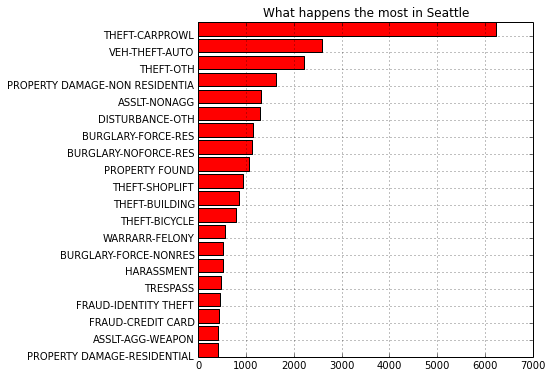

In [18]:
plot_hist_dict(seattle_is14_data,'type_incid_desc', top_k=20, title='What happens the most in')

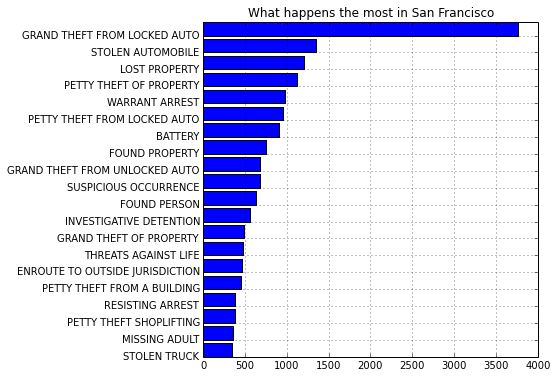

In [19]:
plot_hist_dict(sanfrancisco_is14_data,'type_incid_desc', top_k=20, title='What happens the most in')

Clearly they agree on Car prowl (the most frequent incident for both cities), with bigger magnitude for Seattle. Let see how the incident vary incides in cities neighborhood (district/sector ).

## Combining location and type (what happens the most in Southern or Richmond district S.F)

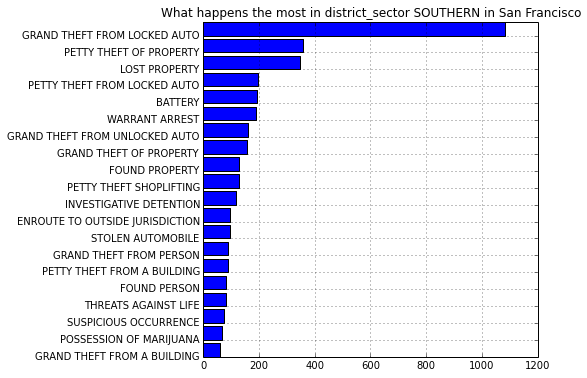

In [20]:
plot_hist_dict(sanfrancisco_is14_data,'type_incid_desc', top_k=20, title='What happens the most in district_sector SOUTHERN in', item_filter= lambda x: x['district_sector'] == 'SOUTHERN')

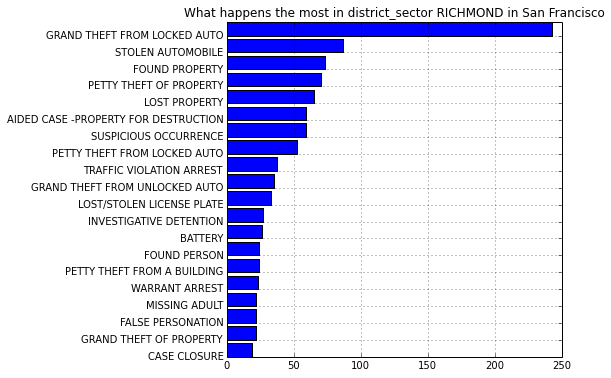

In [21]:
plot_hist_dict(sanfrancisco_is14_data,'type_incid_desc', top_k=20, title='What happens the most in district_sector RICHMOND in', item_filter= lambda x: x['district_sector'] == 'RICHMOND')

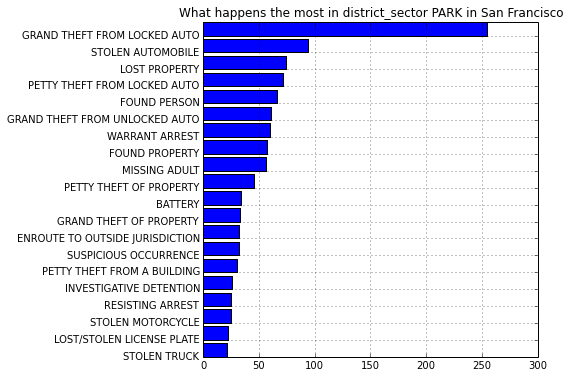

In [22]:
plot_hist_dict(sanfrancisco_is14_data,'type_incid_desc', top_k=20, title='What happens the most in district_sector PARK in', item_filter= lambda x: x['district_sector'] == 'PARK')

Clear,  Grand (or not) theft from locked (or not) auto is the major incident that happens no matter if you are in SOUTHERN S.F or Richmond, or park , what about Park (the same), however SOUTHERN S.F stolen automobile is not well ranked as for the two others, although it is comparable in the absolute number, and the number of incidents in Southern is a way bigger than others. 

## How about locations, but more precisely using Geo-coordinate

In [23]:
# Group location by incident type
def group_loc_by_field_val(data, field='type_incid_desc'):
    type_to_field_val_dict = {}
    for item in data.get('rows', []):
        assert field in item
        if item[field] not in type_to_field_val_dict:
            type_to_field_val_dict[item[field]] = [item.get('loc')]
        else:
            type_to_field_val_dict[item[field]].append(item.get('loc'))
    return type_to_field_val_dict

seattle_grouped_by_type_incid_desc = group_loc_by_field_val(seattle_is14_data, field='type_incid_desc')
san_fransisco_grouped_by_type_incid_desc = group_loc_by_field_val(sanfrancisco_is14_data, field='type_incid_desc')

In [24]:
#import bokeh as bk
#bk.sampledata.download()
from bokeh.plotting import figure, show, output_file, output_notebook, ColumnDataSource
from bokeh.io import output_file, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool
)

Plot the top k (incidents types) for both cities (Separately) 

In [25]:
# Define colors (with palette)
# from bokeh.palettes import Spectral8
colors = ['red', 'green', 'blue', 'yellow', 'orange']

def visu_field_location__(data_set, field='type_incid_desc', top_k = 8, zoom=10):
    """Plotting (Visulaizing) incident Location in the map""" 
    # Sanity check so we have enough different colors for plotting the data
    if top_k > len(colors):
        top_k = len(colors)
    
    assert 'm_loc' in data_set
    # print data_set.get('m_loc')
    map_options = GMapOptions(lat=data_set.get('m_loc').get('lat'),
                              lng=data_set.get('m_loc').get('lon'),
                              map_type="satellite", zoom=zoom) # "roadmap"
    
    # Getting the top k incidents ...
    hist_dict = build_hist_dict(data_set, field)
    top_k_items = sorted ([(k,v) for k,v in hist_dict.iteritems()], key = lambda x: x[1], reverse= True)[:top_k]
    
    # Groupping by field and scatter generation (in different colors)
    groupped_data = group_loc_by_field_val(data_set, field=field) # the group should be filtered according to the top_k_items
    scatter_idx = 0
    # with Gmap plot ... (to debug why it doesn't show inline)
    plot = GMapPlot(x_range=DataRange1d(), y_range=DataRange1d(),
                    map_options=map_options, 
                    title=" {0} incident locations".format(data_set.get('city', 'Nowhere ! ("city" value pb.)')))
    plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())
    for key, _ in top_k_items:

        # Now we prepare a plot for each item in the top_k_items plot (with distingshible color)
        source = ColumnDataSource(
            data=dict(
                lat=[loc.get('lat') for loc in groupped_data[key]],
                lon=[loc.get('lon') for loc in groupped_data[key]],
            )
        )
        circle = Circle(x="lon", y="lat", size=10, fill_color=colors[scatter_idx], fill_alpha=0.8, line_color=None, tags=[key])
        scatter_idx += 1
        plot.add_glyph(source, circle)
       
    return plot

from collections import OrderedDict
from bokeh.charts import Scatter

def visu_field_location(data_set, field='type_incid_desc', top_k=5, zoom=11):
    """Plotting (Visulaizing) incident Location in the map""" 
    # Sanity check so we have enough different colors for plotting the data
    if top_k > len(colors):
        top_k = len(colors)
    
    assert 'm_loc' in data_set
    # print data_set.get('m_loc')
    map_options = GMapOptions(lat=data_set.get('m_loc').get('lat'),
                              lng=data_set.get('m_loc').get('lon'),
                              map_type="satellite", zoom=zoom) # "roadmap"
    
    # Getting the top k incidents ...
    hist_dict = build_hist_dict(data_set, field)
    top_k_items = sorted ([(k,v) for k,v in hist_dict.iteritems()], key = lambda x: x[1], reverse= True)[:top_k]
    
    # Groupping by field and scatter generation (in different colors)
    groupped_data = group_loc_by_field_val(data_set, field=field) # the group should be filtered according to the top_k_items
    scatter_idx = 0
    # with Gmap plot ... (to debug why it doesn't show inline)
    TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
    plot = figure(title=" {0} incident locations".format(data_set.get('city', 'Nowhere ! ("city" value pb.)')),
                tools=TOOLS)

    for key, _ in top_k_items:

        # Now we prepare a plot for each item in the top_k_items plot (with distingshible color)
        source = ColumnDataSource(
            data=dict(
                lat=[loc.get('lat') for loc in groupped_data[key] if loc.get('lat') and loc.get('lon')],
                lon=[loc.get('lon') for loc in groupped_data[key] if loc.get('lat') and loc.get('lon')],
            )
        )
        plot.circle(x="lon", y="lat",source=source,  size=5, fill_color=colors[scatter_idx], fill_alpha=0.5, line_color=None)
        scatter_idx += 1
       
    return plot


In [28]:
output_notebook()
seattle_loc_top_5 = visu_field_location__(seattle_is14_data, field='type_incid_desc', top_k = 2,  zoom=11)
show(seattle_loc_top_5)

BokehJS successfully loaded.

We easly remark a pattern for  'ASSLT-NONAGG' (Non Aggravated Assault) which is a dense (orange cluster) cluster in downtown (I think), for the other (top 5) incidents are most likely uniformly distributed on the map 

In [27]:
sf_loc_top_5 = visu_field_location__(sanfrancisco_is14_data, field='type_incid_desc', top_k = 5)
show(sf_loc_top_5)

# Incidents Date/Time

## time range in Seattle dataset (might be interesting)

Before proceeding in "normalizing" for comparison, let's explore time infromation in Seattle:

The time information is more detailed for Seattle than it is for Sanfrancisco; for Seattle we have 3 fields (Occurred Date or Date Range Start, Occurred Date Range End, Date Reported)
while for Sanfrancisco data we have only Time.

The range information (without prior), might have two meaning which are: either the person who reported the incident is not sure (or he/she constated the incident after a delay for example: vacation, or in the morning ....), or the incident has a duration. What makes the second eventuality relevant is that the time when the case is reported falls with in the range. In other words the incident is reported when it is happening.

To examine (Visualise) these different cases lets define and plot the distribution of : the range (end time - start time), the time to report (date report - start time), and finally  , the report delay (date report - end time) = time to report  - range. 

## Seattle incident duration and time to be reported

In [178]:
from dateutil.parser import parse
from datetime import timedelta

def gen_range_time_2_report_dict(item):
    """ Generat (range) and time to report for a given incident (for Seattle data)"""
    info_time_dict = {}
    # Start datetime
    start_time_date = item['Occurred Date or Date Range Start']
    if start_time_date:
        start_time_date = parse(start_time_date)
    else:
        return {}
    # End datetime
    end_time_date = item['Occurred Date Range End']
    if end_time_date:
        end_time_date = parse(end_time_date)
        info_time_dict['range'] = end_time_date - start_time_date
        info_time_dict['time_to_report'] = parse(item['Date Reported']) - start_time_date
    else:
        info_time_dict['range'] = timedelta(seconds=0)
        info_time_dict['time_to_report'] =  parse(item['Date Reported']) - start_time_date
    return info_time_dict
    
duration_distrib =  [( item['Occurred Date or Date Range Start'], item['Occurred Date Range End'] ,
                      item['Summarized Offense Description']) for item in seattle_is14_data['rows']]

32779 32779


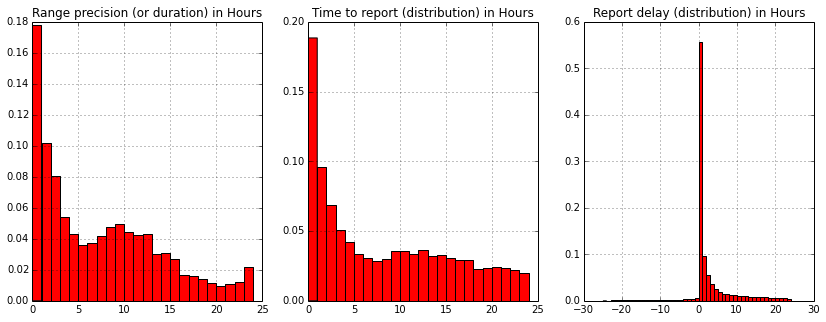

In [183]:
# range_distrib (or duration)
duration_in_hour_data = []
time_to_report_in_hour_data = []
reported_duration = []
interesting_cases = {}
items_with_duration = 0
for item in seattle_is14_data['rows']:
    tmp_item = gen_range_time_2_report_dict(item)
    if any (tmp_item):
        items_with_duration += 1
        duration = tmp_item.get('range', None)
        time_to_report = tmp_item.get('time_to_report', None)
        if duration:
            duration_in_hour_data.append(float(duration.seconds)/3600)
        if time_to_report :
            time_to_report_in_hour_data.append(float(time_to_report.seconds)/3600)
        # report delay 
        delay_in_hour = float(time_to_report.seconds - duration.seconds)/3600
        if delay_in_hour < -10:
            # print item['Summarized Offense Description']
            if  item['type_incid_desc'] in interesting_cases:
                interesting_cases[item['type_incid_desc']] += 1
            else:
                interesting_cases[item['type_incid_desc']] = 1

        reported_duration.append(float(time_to_report.seconds - duration.seconds)/3600)

print items_with_duration, len(seattle_is14_data['rows'])


# Plotting histograms

bins = range(0,25)
bins_sym = range (-25,25)
f, ax = plt.subplots(figsize=(14,5))
plt.subplot(131)
plt.grid()
plt.hist(duration_in_hour_data, bins, normed=True, color=seattle_is14_data['color'])
plt.title('Range precision (or duration) in Hours')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

plt.subplot(132)
plt.hist(time_to_report_in_hour_data, bins, normed=True, color=seattle_is14_data['color'] )
plt.title('Time to report (distribution) in Hours')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.grid()

plt.subplot(133)
plt.hist(reported_duration, bins_sym, normed=True, color=seattle_is14_data['color'] )
plt.title('Report delay (distribution) in Hours')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.grid()

plt.show()

The visualization of the duration or range  of incident (range time end - time start) shows that the majority (almost 18%) of the incidents have less than of one hour as range precision, and the range precision (or duration) is at maximum a day.

Also the time to be reported (given the start time as reference) has a spike in the first bin showing the incidents reported within the first hour (since they started with range start as reference). But more than 80% of the incident are reported after on hour of (start)..

The third graphics is the most interesting among the 3 graphics, so more than the 55% of the incident are reported in the hour after they end, and some of them are reported even before they end (while they were happening). So let see what are these incident that give more chance to the Police to be on time (and if we have the right piece of resolution we can even evaluate the efficiency of the police).

## In Seattle collecting incidents early reported 
by early reported we mean those with negative "Report delay" (see the 3rd graph of the last section)

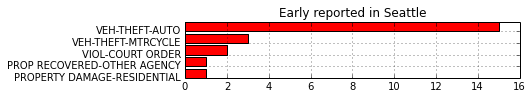

In [188]:
def early_reported_item_filter(item):
    end_time_date = item['Occurred Date Range End']
    if end_time_date:
        end_time_date = parse(end_time_date)
        return (end_time_date >  parse(item['Date Reported']))
    else:
        return False
plot_hist_dict(seattle_is14_data,'type_incid_desc', top_k=20, title='Early reported in', item_filter= early_reported_item_filter)

## In Seattle collecting incidents late reported 

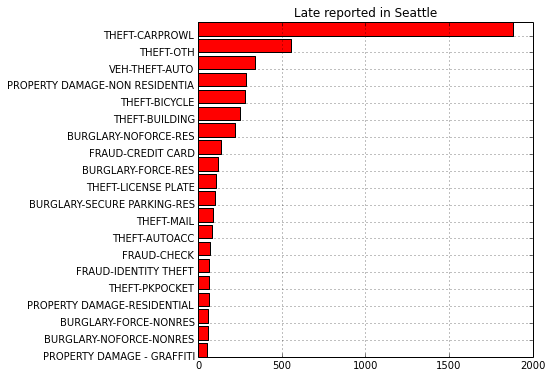

In [189]:
def late_reported_item_filter(item):
    end_time_date = item['Occurred Date Range End']
    if end_time_date:
        end_time_date = parse(end_time_date)
        return (parse(item['Date Reported'])> end_time_date) and  (parse(item['Date Reported']) - end_time_date).seconds > (3600*5)
    else:
        return False
plot_hist_dict(seattle_is14_data,'type_incid_desc', top_k=20, title='Late reported in', item_filter= late_reported_item_filter)

## TOP K Incidents distribution by day hour for Seattle

Let's group the data by day hour ...

In [190]:
# For Seattle how do incidents vary by time of day?
from dateutil.parser import parse # for parsing date

incidents_per_day_hour = {}
hours_by_incident = {}

for incident in seattle_is14_data['rows']:
    hour = parse( incident['Date Reported']).hour
    incident_type = incident['type_incid_desc']
    
    if incident_type not in hours_by_incident:
        hours_by_incident[incident_type]= {'by_hour':{hour:1}}
    else:
        hours_by_incident[incident_type]['by_hour'][hour] = hours_by_incident[incident_type]['by_hour'].get(hour, 0) + 1 

    if hour not in incidents_per_day_hour:
        incidents_per_day_hour[hour] = { 'by_type':{incident_type:1}}
    else:
        incidents_per_day_hour[hour]['by_type'][incident_type] = incidents_per_day_hour[hour]['by_type'].get(incident_type, 0) + 1 

In [192]:
# incidents_per_day_hour

In [193]:
from datetime import datetime
def plot_pie_hour_top_incident(hours, top_k = 5):
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'white']
    #explode = (0.1, 0, 0, 0, 0)
    f, axarr = plt.subplots(len(hours), sharey=True, figsize=(5*len(hours),5*len(hours)))
    for h_idx, hour in enumerate(hours):
        sorted_by_freq = sorted([(item, freq) for item, freq in incidents_per_day_hour[hour]['by_type'].iteritems()],
                                key= lambda x: x[1], reverse= True)  
        axarr[h_idx].pie([item[1] for item in sorted_by_freq][:top_k], labels=[item[0] for item in sorted_by_freq][:top_k], colors=colors, 
                        #explode=explode, 
                         autopct='%1.1f%%', shadow=True, startangle=90)        
        axarr[h_idx].set_title('top '+ str(top_k) + ' incidents from '+ datetime.strptime(str(hour), "%H").strftime("%I %p") +' to '+ datetime.strptime(str(hour+1), "%H").strftime("%I %p"))
        axarr[h_idx].axis('equal')


Relative distribution of the top k incidents given an hour shows that CARPROWL is the most probable incident in Seattle, here the graphics represente hours from 12 pm to 3 am, neverthless the Car prowl keeps the first position with clear difference during all the day. (CARPROWL seams to be popular crime)

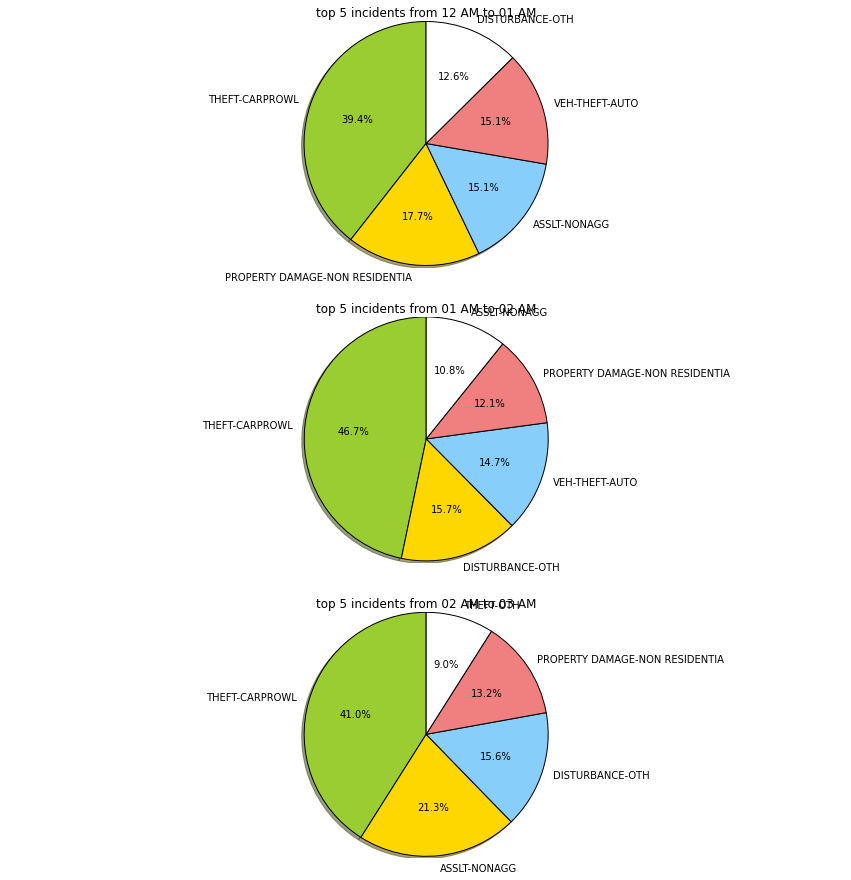

In [200]:
plot_pie_hour_top_incident([0,1,2])

# Bonus: Let's study on Rubbery Categories ...

In [ ]:
# to do  

## Robbery by Categories , and  day Hour 

In [195]:
# Extraction of possible categories within robbery
categs = set()
for incident in hours_by_incident:
    if incident.lower().startswith('robbery'):
        # Extract categories only for robbery
        for categ in incident.split('-')[1:]:
            categs.add(categ)
categs = list(categs)
print categs


['BUSINESS', 'RESIDENCE', 'WEAPON', 'BODYFORCE', 'GUN', 'STREET', 'BANK']


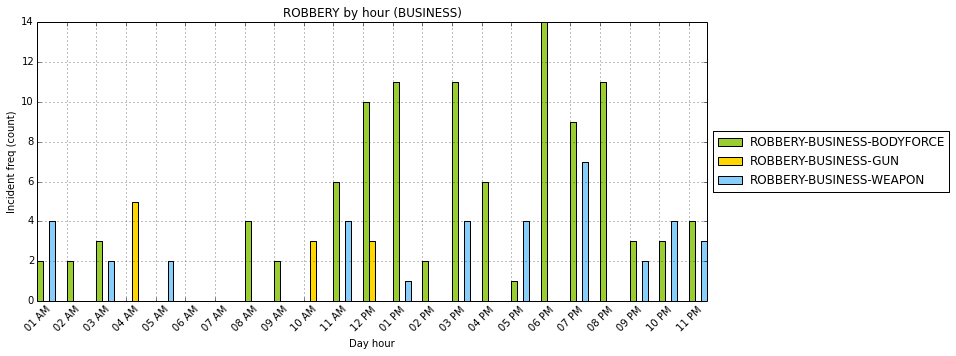

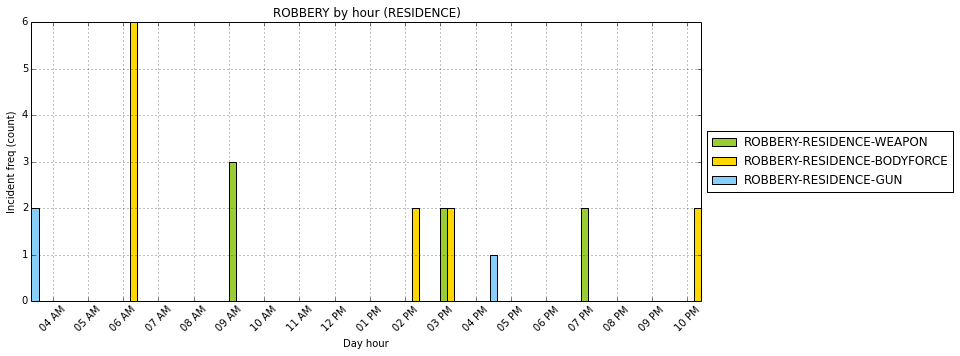

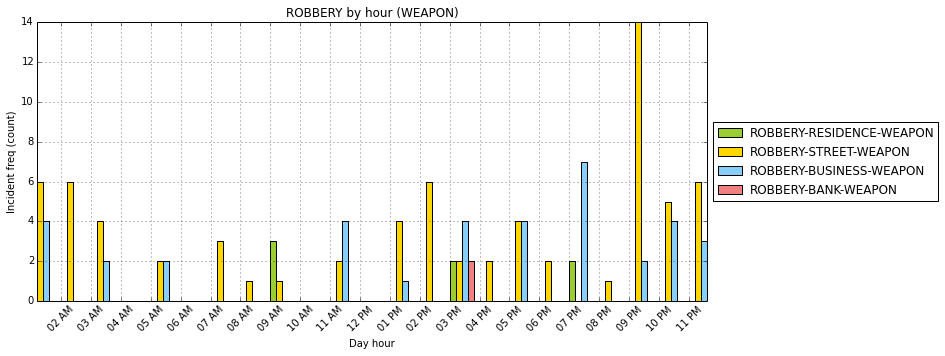

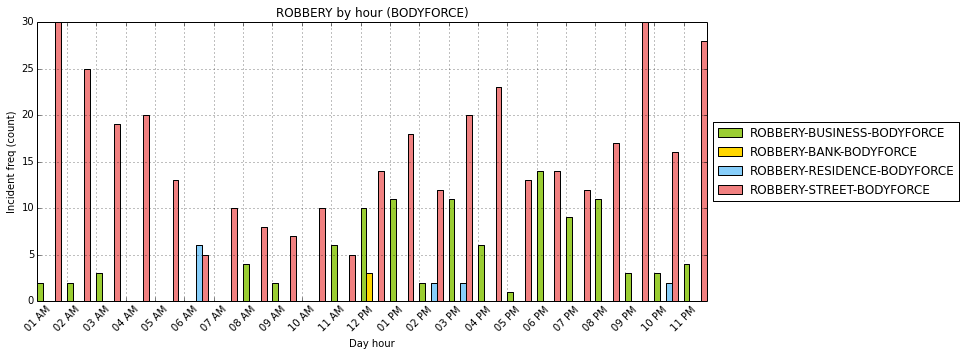

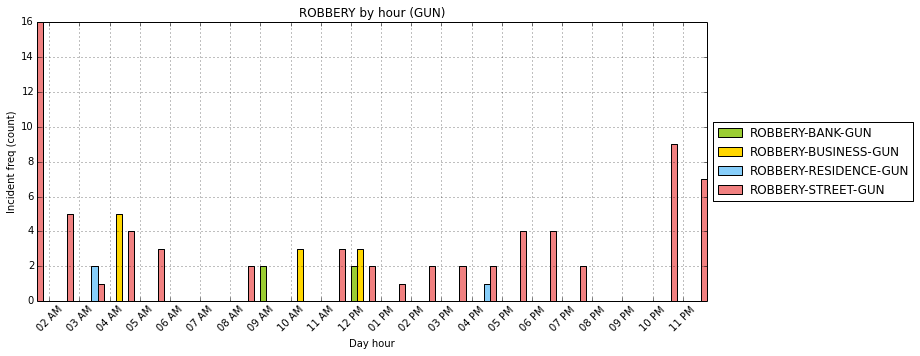

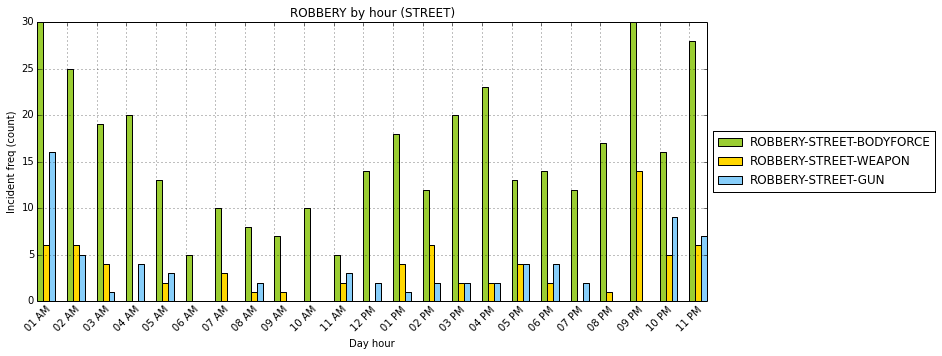

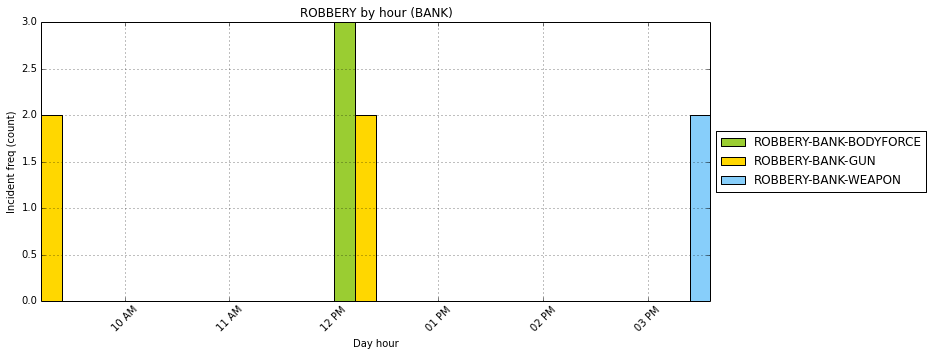

In [196]:
#from datetime import datetime
#
#f, ax = plt.subplots(figsize=(12,5))
#ax.set_title('Incident by hour')
#ax.set_xlabel('Day hour')
#ax.set_ylabel('Incident freq (count)')
        
#for incident, data in  hours_by_incident.iteritems():
#    if incident.lower().startswith('robbery') :# and 'bank'  in incident.lower():        
#        ax.set_xticks(range(24))
#        ax.set_xticklabels([datetime.strptime(str(h), "%H").strftime("%I %p") for h in range(24)], rotation=45  )
#        x, y = zip(* sorted ([(hour, count) for hour, count in data['by_hour'].iteritems()], key = lambda x : x[0]))
#        ax.plot(x,y, marker='o', linestyle='--', label = incident)
#        ax.grid()
#        #ax.hold(True)
#        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#        #f.grid()


import numpy as np
# plot by categ 
def robbery_plot(categ):
    assert categ in categs
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'white']
    f, ax = plt.subplots(figsize=(12,5))
    ax.set_title('ROBBERY by hour ('+categ+')')
    ax.set_xlabel('Day hour')
    ax.set_ylabel('Incident freq (count)')
    ax.set_xticks(range(24))  
    ax.set_xticklabels([datetime.strptime(str(h), "%H").strftime("%I %p") for h in range(24)], rotation=45  )
    ax.grid()
    idx = 0
    for incident, data in  hours_by_incident.iteritems():
        labels_by_level =  incident.split('-')
        
        if labels_by_level[0] == 'ROBBERY'  and categ in labels_by_level[1:]:
            #print labels_by_level
            width = 0.2
            x, y = zip(* sorted ([(hour, count) for hour, count in data['by_hour'].iteritems() if count and hour], key = lambda x : x[0]))
            x= list(x)
            y= list(y)
            #ax.plot(x,y, marker='o', linestyle='--', label = incident)
            ax.bar(np.array(x)+ idx*width,y, width= width, label = incident, color = colors[idx])
            idx += 1
            
            #ax.hold(True)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            #f.grid()

for categ in categs:
    robbery_plot(categ)

1. Bank robbery
interestingly Bank robbery are more likely to happen during the middle of the day while the Gun Robbery is equally distributed between day and night. Robbery with weapon (maybe heavier than guns) are more likely to happen during night while during the day the bodyforce is more probable 

2. Gun is more used for street Robbery which has a pic at night between 12 AM and 1 AM ...

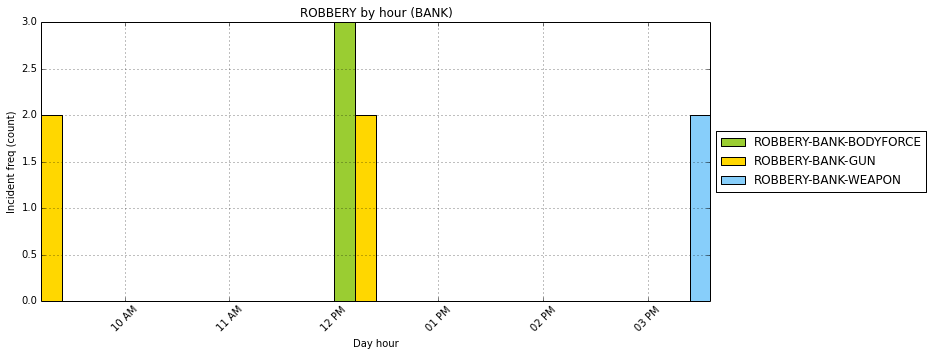

In [197]:
robbery_plot('BANK')

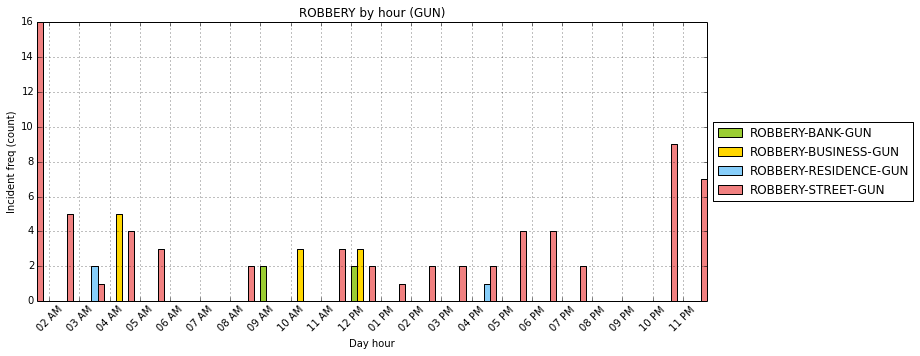

In [198]:
robbery_plot('GUN')

The bodyforce is clearly more used for STREET ROBBERY 

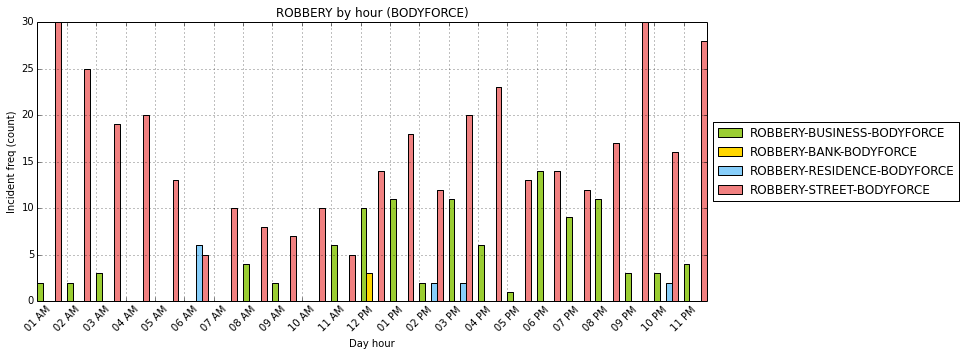

In [199]:
robbery_plot('BODYFORCE')

# Incident month to month in the Summer 2014 dataset

In [31]:
# to be continued 